In [ ]:
import re
import pandas as pd
import numpy as np
import scipy.sparse
from scipy.sparse import csr_matrix

import spacy 
import en_core_web_sm


from scipy.cluster.hierarchy import linkage, fcluster ,dendrogram
from scipy.spatial.distance import squareform

from collections import defaultdict
from matplotlib.colors import rgb2hex, colorConverter

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from matplotlib import pyplot as plt    
from matplotlib import cm as cm



## Importing DBLP DATASET 
#### SELECTING Titles and Years for the last 20 years

In [157]:
df = pd.read_csv("DBLP.csv")
df = df[["Title","Year"]][df['Year']>1999]
df.head()

,Title,Year
3,A characterization of rational D0L power series.,2011.0
7,Equational weighted tree transformations.,2012.0
8,Merged processes: a new condensed representati...,2006.0
9,Verifying a simplification of mutual exclusion...,2013.0
15,Trace- and failure-based semantics for respons...,2014.0


 Now and in order to tokenize our data we implement a class tokenizer from spacy and set the different rules for the tokenization 

In [159]:
class MyTokenizer:
    def __init__(self):
        self.lemmatizer = en_core_web_sm.load()
        
    def __call__(self, document):
        res = []
        for t in self.lemmatizer(document):
            if not t.is_stop and not t.is_punct and re.match(r'^[a-zA-ZÀ-ÿ]+$', t.lemma_):
                res.append(t.lemma_)
        return res

After that we initialize CountVectorizer from sklearn and we pass our tokenizer as an argument.

For performance purpose We decided to take in count the 1500 most frequent terms in a year 

In [160]:
vect = CountVectorizer(tokenizer = MyTokenizer(),max_features=1500)

### constructing the features vectors vocabulary 

In the following blocks we implement a method that has as purpose the construction of the feature vectors for each word we will have a line in a dictionary where the word is the key and the value is a feature vector of 20 values containing the frequency of the term in each year of the 20 past years.



In [161]:
def get_elt(w):
    return {
         w :
         [0] * 20
    }

In [162]:
import pickle
def get_vocabulary(vect,p=20):
    vocabulary = {}
    for i in range(p):
        year = 2019 - i
        print("year :",year)
        df_year = df[df['Year'] == year]
        dtm = vect.fit_transform(df_year['Title'])
        freqs = np.squeeze(np.asarray(np.sum(dtm.todense(), axis = 0)))
        words = vect.get_feature_names()
        for k,v in zip(words,freqs):
            if (k in vocabulary.keys()):
                vocabulary[k][i] = v
            else :
                w = get_elt(k)
                w[k][i] = v
                vocabulary.update(w)
    import _pickle as pickle

    with open('vocabulary.txt', 'wb') as file:
         file.write(pickle.dumps(vocabulary)) # use `pickle.loads` to do the reverse
    return vocabulary


In [163]:
vocabulary = get_vocabulary(vect)

year : 2019
year : 2018
year : 2017
year : 2016
year : 2015
year : 2014
year : 2013
year : 2012
year : 2011
year : 2010
year : 2009
year : 2008
year : 2007
year : 2006
year : 2005
year : 2004
year : 2003
year : 2002
year : 2001
year : 2000


In [164]:
def get_coord(a,b):
    n = 0
    for i in range(len(a)):
        for j in range(len(a)):
            if (a[i] >= b[i] and a[j] >= b[j]) or (a[i] <= b[i] and a[j] <= b[j]) :
                n = n + 1                
    return (n,len(a)*len(a)-n)


In [165]:
def kendall(v1,v2,n):
    Nc,Nd = get_coord(v1,v2)
    return ((Nc-Nd) / ((.5 * n)*(n-1)))


In [166]:
def get_coo_evolution(vocab,vocabulary,p):
    n = len(vocabulary)
    flags = [False] * p
    mat = []
    for i,v in enumerate(vocab):
        row = []
        for j,w in enumerate(vocab):
            if(j < i):
                row.append(mat[j][i])
            else :
                row.append(kendall(v,w,p))
        mat.append(row)
        if i % 200 == 0:
            a = float("{0:.2f}".format((i/n)*100))
            print("Processed {} / {} : {} %".format(i,n,a))
            
    return csr_matrix(mat)
            

In [168]:
vectors  = np.array(list(vocabulary.values()))
coo_evolution = get_coo_evolution(vectors,vocabulary,20)
type(coo_evolution)
 
scipy.sparse.save_npz('coo_evolution2.npz',coo_evolution) # use `pickle.loads` to do the reverse

coo_evolution = scipy.sparse.load_npz('coo_evolution2.npz')

Processed 0 / 3920 : 0.0 %
Processed 200 / 3920 : 5.1 %
Processed 400 / 3920 : 10.2 %
Processed 600 / 3920 : 15.31 %
Processed 800 / 3920 : 20.41 %
Processed 1000 / 3920 : 25.51 %
Processed 1200 / 3920 : 30.61 %
Processed 1400 / 3920 : 35.71 %
Processed 1600 / 3920 : 40.82 %
Processed 1800 / 3920 : 45.92 %
Processed 2000 / 3920 : 51.02 %
Processed 2200 / 3920 : 56.12 %
Processed 2400 / 3920 : 61.22 %
Processed 2600 / 3920 : 66.33 %
Processed 2800 / 3920 : 71.43 %
Processed 3000 / 3920 : 76.53 %
Processed 3200 / 3920 : 81.63 %
Processed 3400 / 3920 : 86.73 %
Processed 3600 / 3920 : 91.84 %
Processed 3800 / 3920 : 96.94 %


In [170]:
coev = coo_evolution.todense()
max_sim = np.max(coev)
max_sim

2.1052631578947367

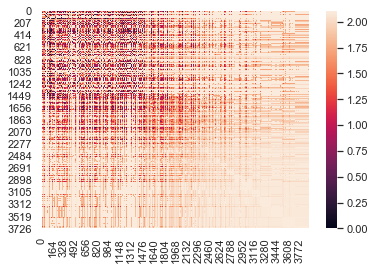

In [173]:
import seaborn as sns; sns.set()
ax = sns.heatmap(coev)

In [ ]:
dissimilarity = max_sim - np.abs(coo_evolution.todense())
hierarchy = linkage(squareform(dissimilarity), method='ward')
labels = fcluster(hierarchy, 0.5, criterion='distance')

In [ ]:
class Clusters(dict):
    def _repr_html_(self):
        html = '<table style="border: 0;">'
        for c in self:
            hx = rgb2hex(colorConverter.to_rgb(c))
            html += '<tr style="border: 0;">' \
            '<td style="background-color: {0}; ' \
                       'border: 0;">' \
            '<code style="background-color: {0};">'.format(hx)
            html += c + '</code></td>'
            html += '<td style="border: 0"><code>' 
            html += repr(self[c]) + '</code>'
            html += '</td></tr>'

        html += '</table>'

        return html
    
def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))
    
    cluster_classes = Clusters()
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l
    
    return cluster_classes

In [ ]:

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
B =dendrogram(
    hierarchy,
    labels=np.array(list(vocabulary.keys())),
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
ax=plt.gca()
ax.tick_params(axis='x', which='major', labelsize=8)
ax.tick_params(axis='y', which='major', labelsize=15)
plt.xlabel("terms")
    #plt.set_size_inches(18.5, 10.5)
plt.ylabel('Distance')
plt.suptitle("terms"+" clustering for DBLP's Coevolution of terms ", fontweight='bold', fontsize=16);
plt.show()

In [ ]:
get_cluster_classes(B)

In [178]:
vect2 = TfidfVectorizer(tokenizer = MyTokenizer(),max_features=1000)
vocabulary2 = get_vocabulary(vect2)
#vocabulary2 = pickle.load( open( "vocabulary2.txt", "rb" ) )
len(vocabulary2)

year : 2019
year : 2018
year : 2017
year : 2016
year : 2015
year : 2014
year : 2013
year : 2012
year : 2011
year : 2010
year : 2009
year : 2008
year : 2007
year : 2006
year : 2005
year : 2004
year : 2003
year : 2002
year : 2001
year : 2000


2372

In [180]:
vectors2  = np.array(list(vocabulary2.values()))
coo_evolution2 = get_coo_evolution(vectors2,vocabulary2,20)
coev2 = coo_evolution2.todense()
max_sim = np.max(coev2)
max_sim

Processed 0 / 2372 : 0.0 %
Processed 200 / 2372 : 8.43 %
Processed 400 / 2372 : 16.86 %
Processed 600 / 2372 : 25.3 %
Processed 800 / 2372 : 33.73 %
Processed 1000 / 2372 : 42.16 %
Processed 1200 / 2372 : 50.59 %
Processed 1400 / 2372 : 59.02 %
Processed 1600 / 2372 : 67.45 %
Processed 1800 / 2372 : 75.89 %
Processed 2000 / 2372 : 84.32 %
Processed 2200 / 2372 : 92.75 %


2.1052631578947367

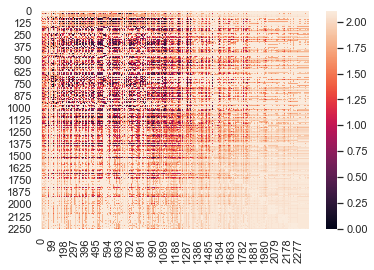

In [181]:
ax = sns.heatmap(coev2)

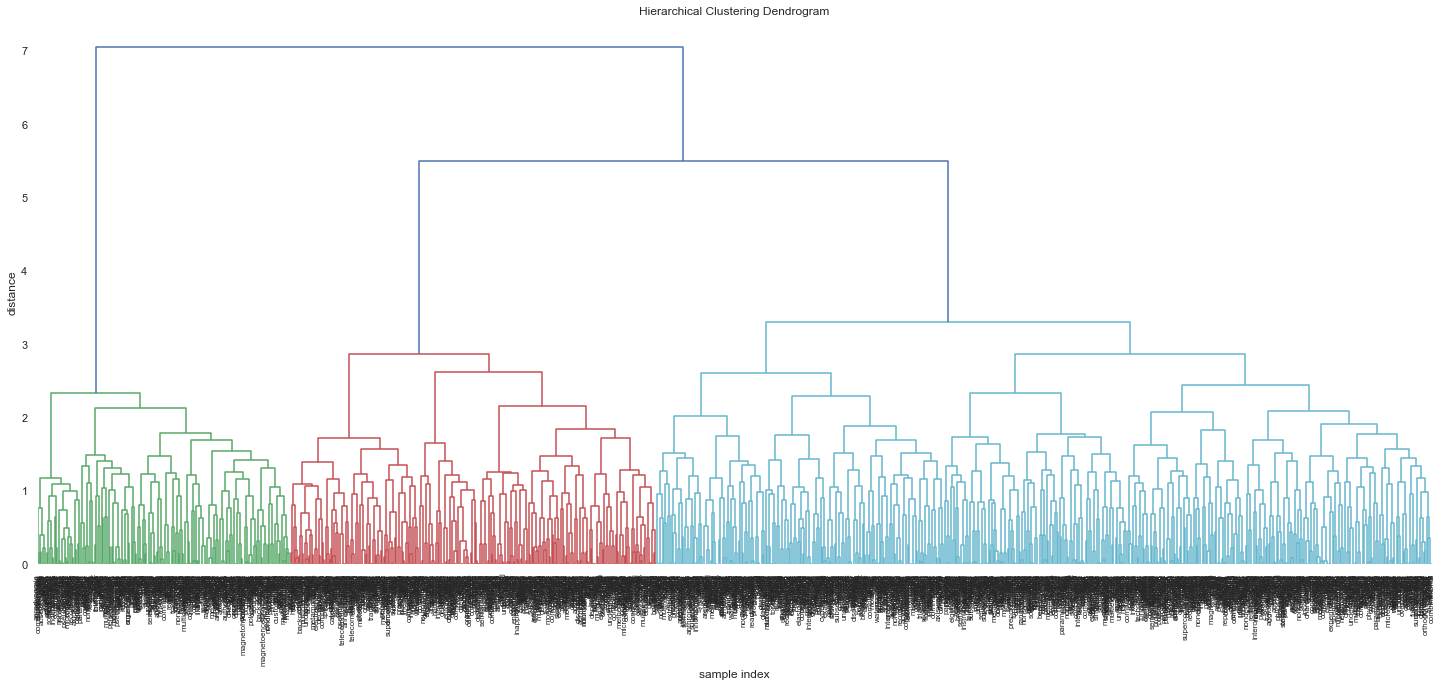

g
r
c


In [182]:
dissimilarity2 = max_sim - np.abs(coo_evolution2.todense())
hierarchy2 = linkage(squareform(dissimilarity2), method='ward')
labels2 = fcluster(hierarchy2, 0.2, criterion='distance')

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
A = dendrogram(
    hierarchy2,
    p=10,
    labels=np.array(list(vocabulary.keys())),
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()
get_cluster_classes(A)

In [183]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

x_sparse = sparse.csr_matrix(vocabulary)

similarities = cosine_similarity(x_sparse)
print('pairwise dense output:\n {}\n'.format(similarities))


TypeError: no supported conversion for types: (dtype('O'),)

In [ ]:
import matplotlib.pylab as plt 
plt.spy(similarities)

  ### lets try a smaller period ex 10years

In [184]:
df2 = df[["Title","Year"]][df['Year']>2009]
df2['Year'].value_counts()

2017.0    11227
2016.0     9592
2018.0     9491
2015.0     8698
2014.0     8399
2013.0     8064
2012.0     6828
2011.0     6614
2010.0     6444
2019.0       39
Name: Year, dtype: int64

In [185]:
vocabulary3=get_vocabulary(vect,10)
vocabulary3 = pickle.load( open( "vocabulary2.txt", "rb" ) )


year : 2019
year : 2018
year : 2017
year : 2016
year : 2015
year : 2014
year : 2013
year : 2012
year : 2011
year : 2010


In [191]:
vectors3  = np.array(list(vocabulary3.values()))
coo_evolution3 = get_coo_evolution(vectors3,vocabulary3,10)
coev3 = coo_evolution3.todense()
max_sim3 = np.max(coev3)
coev3.shape
len(coev3)


Processed 0 / 158 : 0.0 %


158

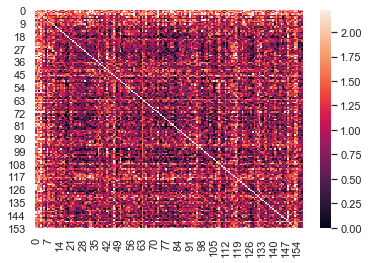

In [192]:
ax = sns.heatmap(coev3)

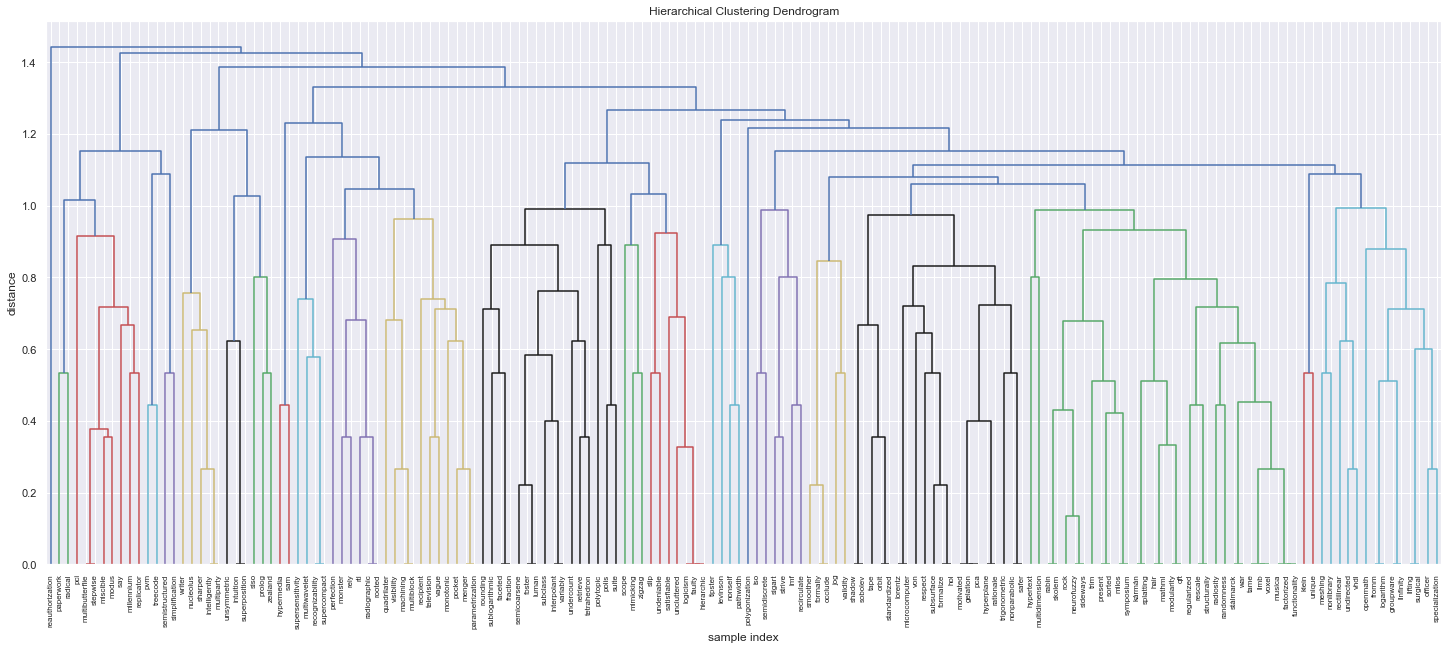

g,"['paperwork', 'radical', 'prolog', 'zealand', 'siso', 'mimicking', 'zigzag', 'scope', 'hypertext', 'multidimension', 'rabin', 'skolem', 'neurofuzzy', 'sideways', 'rock', 'present', 'sorted', 'milos', 'symposium', 'trim', 'kármán', 'splatting', 'hair', 'mathml', 'modularity', 'qft', 'rescale', 'structurally', 'regularized', 'radiosity', 'randomness', 'stålmarck', 'war', 'limb', 'voxel', 'tame', 'factorized', 'functionality', 'musica', 'hair']"
r,"['multibutterflie', 'stepwise', 'miscible', 'modus', 'millennium', 'replicator', 'say', 'pci', 'hypermedia', 'sam', 'slip', 'undeniable', 'faulty', 'hierarchic', 'logicism', 'uncluttered', 'satisfiable', 'klein', 'unique']"
c,"['pvm', 'treecode', 'recognizability', 'supercompact', 'multiwavelet', 'supersensitivity', 'nonself', 'pathwidth', 'levinson', 'tipster', 'meshing', 'nonlibrary', 'undirected', 'vhdl', 'rectilinear', 'fromm', 'logarithm', 'groupware', 'linfinity', 'lifting', 'surgical', 'officer', 'specialization', 'openmath']"
m,"['semistructured', 'simplification', 'monster', 'rely', 'radiographic', 'rooted', 'rtl', 'perfection', 'iso', 'semidiscrete', 'sigart', 'strive', 'lmf', 'recirculate']"
y,"['intelligently', 'multiparty', 'sharper', 'nucleolus', 'writer', 'machining', 'multiblock', 'visibility', 'quadrilater', 'television', 'vague', 'menger', 'parametrization', 'pocket', 'monotonic', 'recipient', 'formally', 'occlude', 'smoother', 'jog', 'validity']"
k,"['intuition', 'superposition', 'unsymmetric', 'faceted', 'fraction', 'sublogarithmic', 'rounding', 'foster', 'luman', 'semicoarsene', 'interpolant', 'variably', 'subclass', 'retrieve', 'tetrahedron', 'undercount', 'polis', 'suite', 'polytopic', 'shadow', 'sobolev', 'orbit', 'standardized', 'tape', 'lorentz', 'microcomputer', 'formalize', 'hol', 'subsurface', 'respect', 'von', 'gelation', 'pca', 'motivated', 'hyperplane', 'rationale', 'nonparabolic', 'safer', 'trigonometric']"
b,"['sigart', 'polygonization', 'reauthorization']"


In [193]:
dissimilarity3 = max_sim3 - np.abs(coo_evolution3.todense())
hierarchy3 = linkage(squareform(dissimilarity3), method='average')
labels3 = fcluster(hierarchy3, 0.2, criterion='distance')

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
C = dendrogram(
    hierarchy3,
    labels=np.array(list(vocabulary.keys())),
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()
get_cluster_classes(C)